In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bankportugal/bank-additional-full (4).csv


# Librerias

Importo las librerías que voy a utilizar en el análisis.

In [51]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)}) #Imágenes más grandes
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, f1_score,accuracy_score,roc_auc_score,plot_roc_curve

import warnings
warnings.filterwarnings("ignore")

   # Variables de entrada:
   ## bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   
   ## related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
   ## other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
   ## social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Carga de los datos

In [3]:
data = pd.read_csv("/kaggle/input/bankportugal/bank-additional-full (4).csv",delimiter=";")

Veamos si se importaron de manera correcta los datos.

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Información básica de las columnas.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Se observa que tenemos 11 variables categóricas, por lo cual tendremos que hacer el tratamiento pertinente de las mismas. A su vez se observa que no hay entradas nulas, lo cual en principio podría ser bueno pero suele suceder que se utilizan valores fuera de escala o palabras distintas para representar valores nulos y Pandas no lo detectará.

Veamos un aspecto importante, el cual es de qué manera está distribuida la variable objetivo a través del dataset.

In [6]:
data["y"].value_counts()/(data["y"].count())

no     0.887346
yes    0.112654
Name: y, dtype: float64

Tenemos dos valores categóricos en la variable de salida: si y no. Se observa que la cantidad de respuestas negativas se corresponde con el 88% del dataset. Como la variable objetivo está sesgada es necesario utilizar técnicas de undersampling u oversampling ya que algunos algoritmos de ML son sensibles a entradas desbalanceadas. Esto es muy importante ya que si hiciera un modelo que predijera que no para la variable objetivo para todos los casos, tendría un valor de precisión del 89% si lo ejecuto en este dataset.
A su vez este es un problema de clasificación por lo que usaremos distintos modelos tales como RidgeRegression, SVM, Decision Trees, etc.

In [7]:
data["y"] = data["y"].apply(lambda x: 1 if x=="yes" else 0)

Veamos las distintas categorías de las variables categoricas.

In [8]:
cat_cols = data.select_dtypes("object").columns.to_list()
for i in cat_cols:
    print("* " + i+":")
    print(data[i].unique())
    print("-"*80)

* job:
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--------------------------------------------------------------------------------
* marital:
['married' 'single' 'divorced' 'unknown']
--------------------------------------------------------------------------------
* education:
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--------------------------------------------------------------------------------
* default:
['no' 'unknown' 'yes']
--------------------------------------------------------------------------------
* housing:
['no' 'yes' 'unknown']
--------------------------------------------------------------------------------
* loan:
['no' 'yes' 'unknown']
--------------------------------------------------------------------------------
* contact:
['telephone' 'cellular']
-----------------------------------------

Se observa que hay etiquetas utilizadas para representar valores nulos tales como *unknown*. Veamos la distribución de estos valores con respecto a la variable objetivo y como podemos tratarlos.

In [9]:
def Subplots_y(func,df,cols,nrows,ncols,hue=None):
    fig,ax = plt.subplots(ncols=ncols,nrows=nrows)
    if(ncols*nrows != (len(cols))):
        print("No coincide el numero de columnas")
        return 0
    for i in range(len(cols)):
        func(data=df,y=data[cols[i]],ax=ax[i%nrows][i%ncols],hue=hue)
        plt.title(cols[i])
    return 0

def Subplots_x(func,df,cols,nrows,ncols,hue=None):
    fig,ax = plt.subplots(ncols=ncols,nrows=nrows)
    if(ncols*nrows != (len(cols))):
        print("No coincide el numero de columnas")
        return 0
    for i in range(len(cols)):
        func(data=df,x=data[cols[i]],ax=ax[i%nrows][i%ncols],hue=hue)
        plt.title(cols[i])
    return 0

0

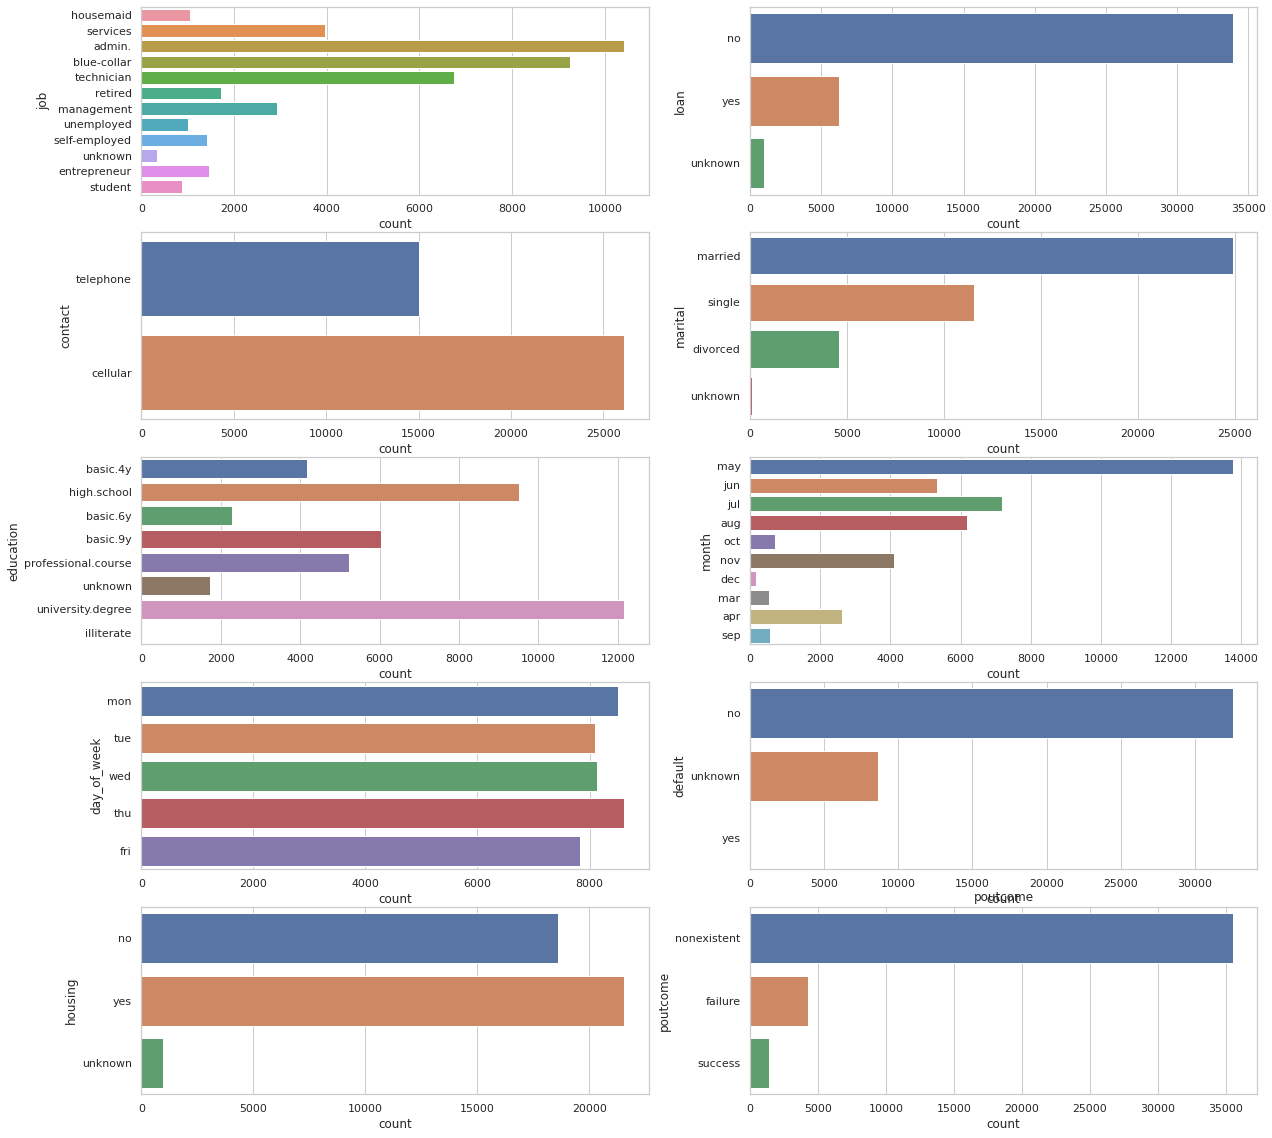

In [10]:
Subplots_y(sns.countplot,data,cat_cols,5,2)

De las variables categóricas se pueden desprender distintos aspectos. Por ejemplo:

Los clientes en su mayoría tienen como trabajo admin, blue-collar, technician.

La mayoría de los contactos fue realizado por celular.

La mayoría posee título universitario de los que son contactados.

En promedio la cantidad de llamados durante los días son aproximadamente iguales.

Gran cantidad de las personas no tienen préstamos para sus casas.

La mayoría de las personas llamadas están casadas.

La mayor cantidad de contactos se realizó en Mayo.

La mayoría no tiene deuda de crédito.

Los missing values se representan con el nombre unknown.

# Exploratory Data Analysis

Comencemos con el tratamiento de las variables categóricas.
De la parte anterior se observa que los missing values se representan con el nombre unknown. Veamos la distribución de estos en función de la variable a predecir.

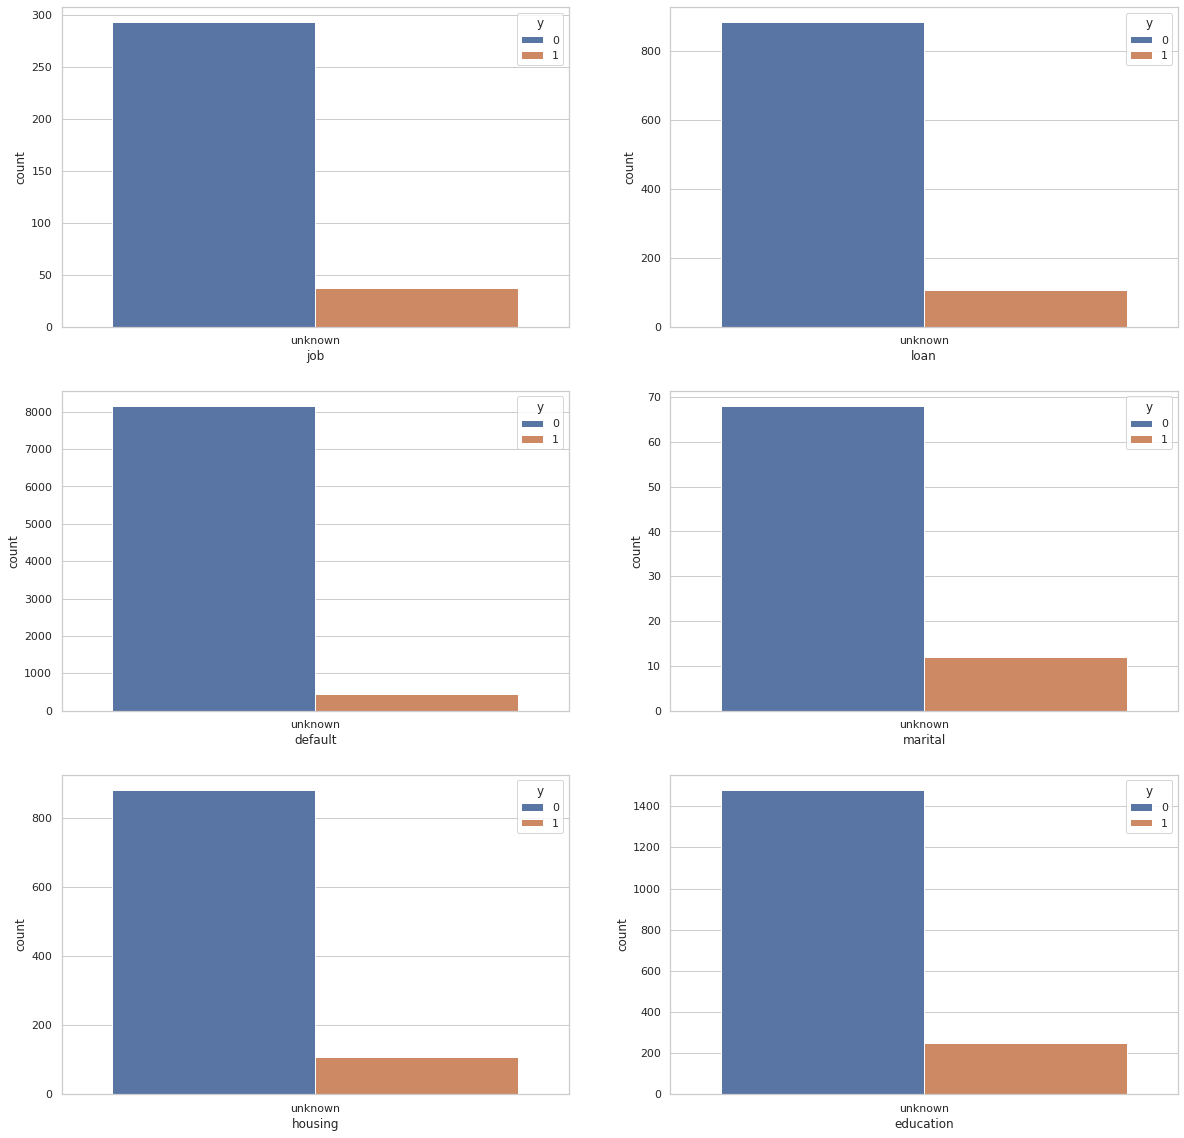

In [11]:
cols_w_unknowns = ["job","marital","housing","loan","default","education"]
fig,ax = plt.subplots(ncols=2,nrows=3)
for i in range(len(cols_w_unknowns)):
    sns.countplot(data=data,x=data[data[cols_w_unknowns[i]]=="unknown"][cols_w_unknowns[i]],hue="y",ax=ax[i%3][i%2])

La cantidad de valores desconocidos es despreciable comparado con la cantidad de datos en el dataset. Pero representa un 10% de los objetivos positivos. Por esta razón no descartaré los datos y los reemplazaré por la correspondiente moda. Podría dejarlos como una variable más para ajustar pero al obtener las variables dummy tendría una mayor dimensionalidad.

In [12]:
for i in cols_w_unknowns:
    data.loc[data[i] == "unknown",i] = data[i].mode()[0]

Analicemos el mapa de correlación, con este podemos ver si existe relación lineal entre las variables numéricas.

<AxesSubplot:>

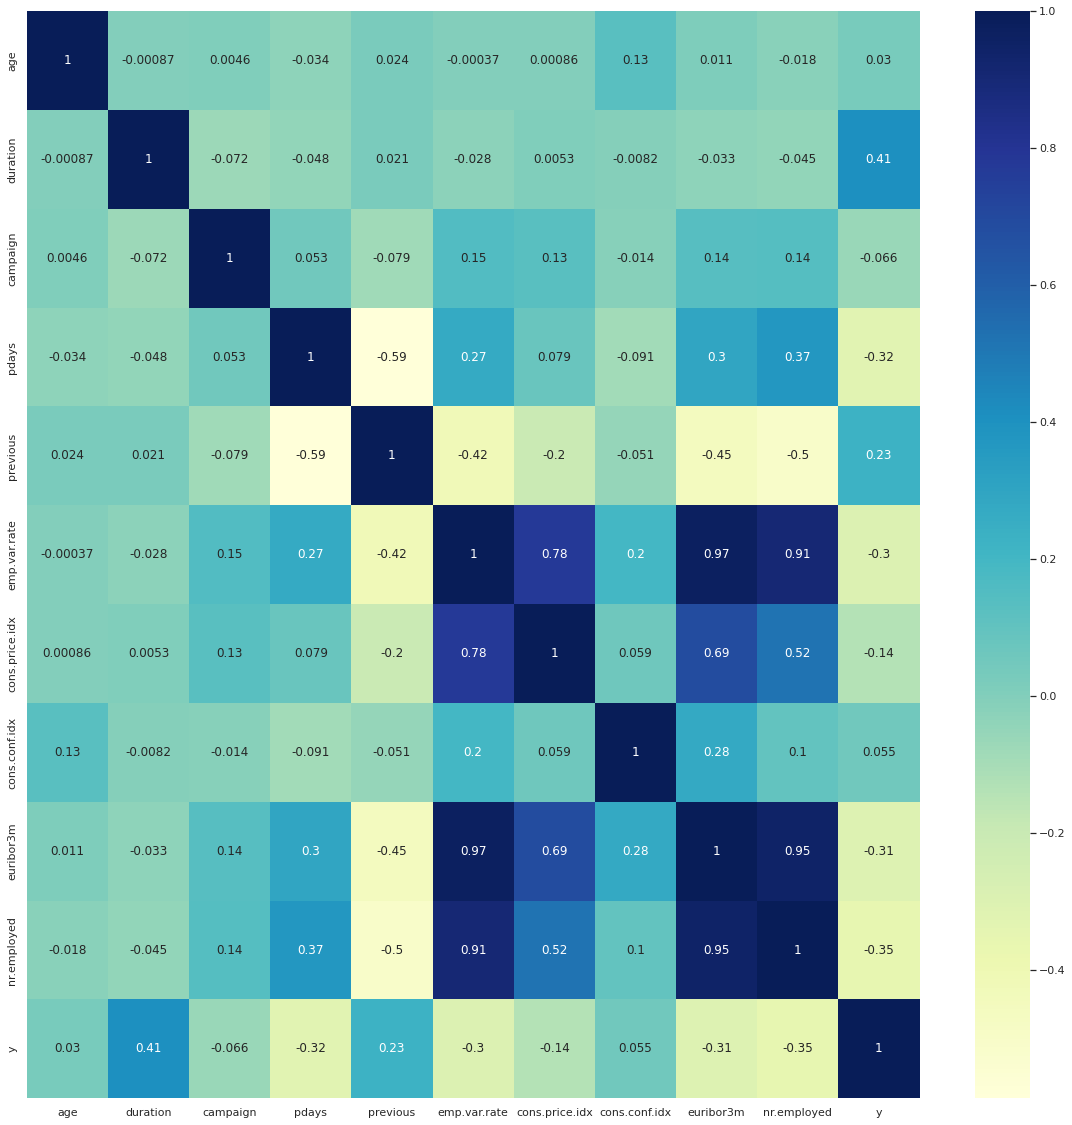

In [13]:
sns.heatmap(data.corr(),cmap="YlGnBu",annot=True)

Se observa que la variable de salida "y" posee una fuerte correlación con nr.employed, duration, plays, etc. Esto debería verse reflejado en el peso de estas variables al realizar el entrenamiento del modelo. Es importante aclarar que correlación cero no implica que no haya relación, sólo que si existe, ésta no es lineal.

Procedamos a ver los outliers de las variables numéricas. Para esto utilizo boxplots, los cuales toma como outliers a los valores que superan los whiskers. Estos pueden ser tanto valores fuera de rango que representan missing values como valores mal anotados.

In [14]:
#Tomo las categorías numéricas
numeric_cols = data.select_dtypes("number").columns.to_list()
numeric_cols.pop() # Saco la categoría "y"
print(numeric_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


0

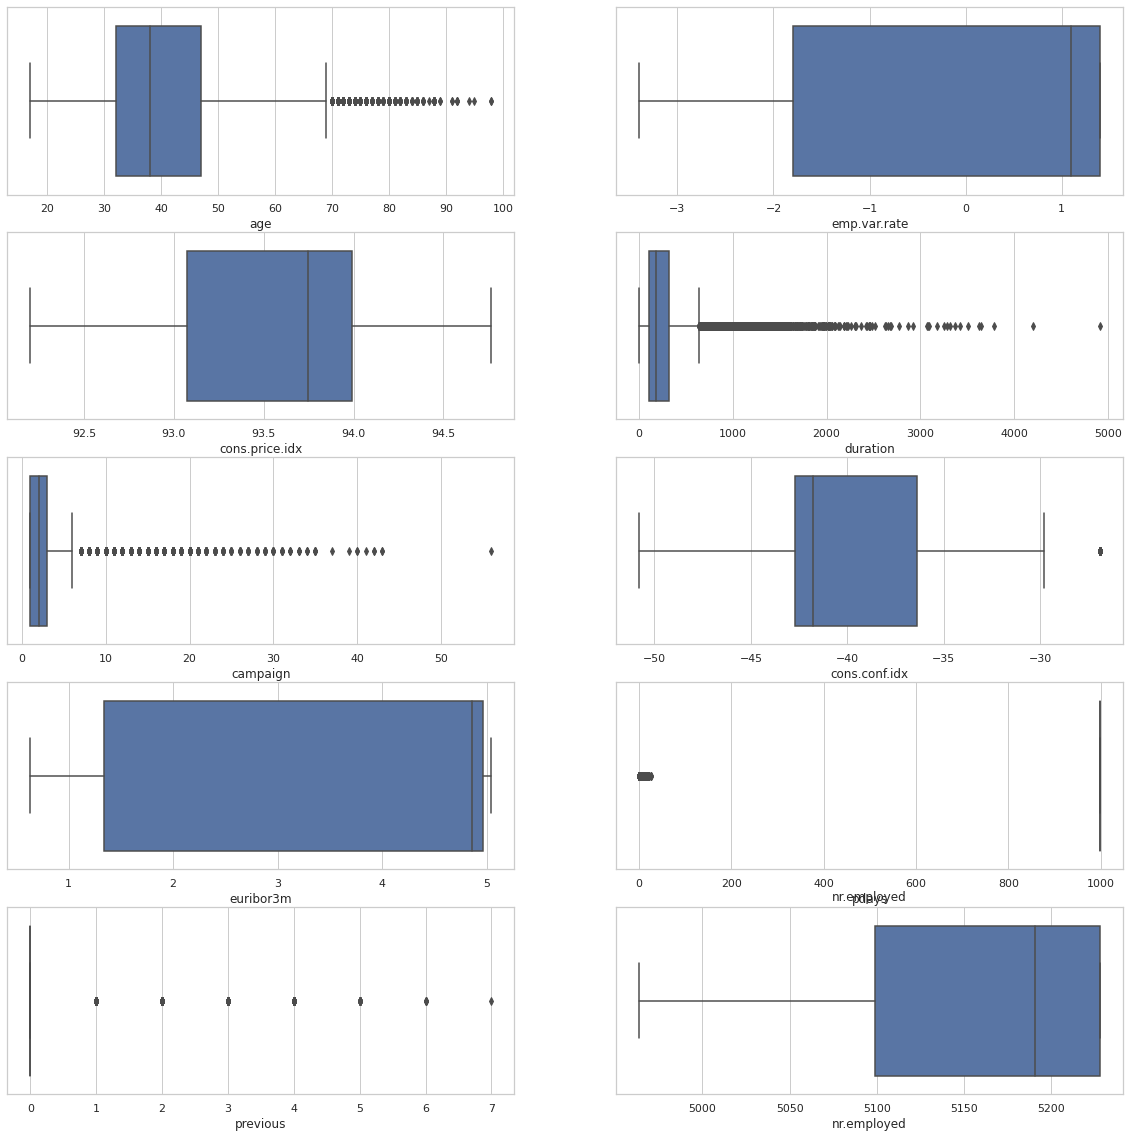

In [15]:
Subplots_x(sns.boxplot,data,numeric_cols,nrows=5,ncols=2)

En primer lugar, la columna durations debe ser descartada ya que luego del contacto con la persona uno ya sabe el resultado de la variable objetivo. A su vez se observa que pdays posee la mayoría de los datos en 999, que corresponde según la referencia a clientes contactados por primera vez.

Se observa que hay gran cantidad de outliers en campaing, previous, durations y age. Es más, gran cantidad de los valores de previous está centrado en cero. 

Veamos los kde de las variables numéricas para ver si presentan asimetrías que podamos corregir.

Por ahora procedo a descartar la columna durations.

In [16]:
data.drop("duration",axis=1,inplace=True)

Obtengamos las variables dummies, utilizando Pandas. La contra de esto es que la dimensionalidad del problema aumenta en gran cantidad. Esta dimensionalidad trataremos de reducirla en los siguientes pasos.

Obtengamos los kde de las variables numéricas para ver si las distribuciones presentan asintotas largas, lo cual representa outliers.

In [17]:
 num_cols = list(data.select_dtypes("number").columns)
len(num_cols)

10

0

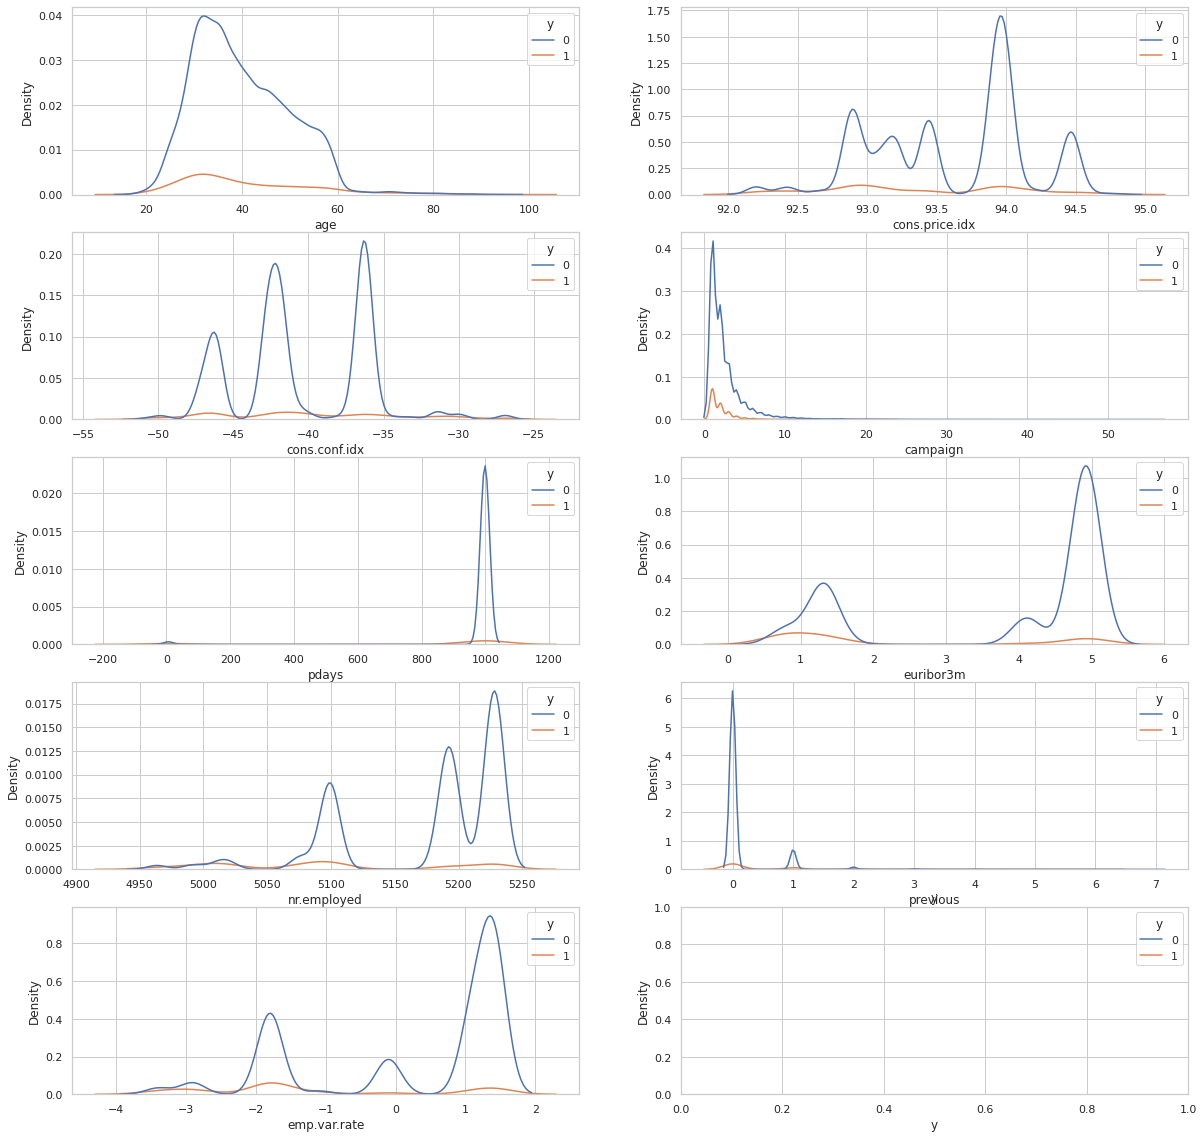

In [18]:
Subplots_x(sns.kdeplot,data,num_cols,5,2,hue="y")

Observemos pdays que tiene un gran pico en el extremo derecho, al igual que en el boxplot.

In [19]:
data["pdays"].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

Tenemos muchos valores nulos en pdays y a mi criterio no aporta información relevante. Procedo a descartarla.

In [20]:
data.drop("pdays",axis=1,inplace=True)

Separo las variables categóricas en sus distintas categorías.

In [21]:
data_dummy = pd.get_dummies(data)

In [22]:
data_dummy.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,0,1,0,0,0,0,1,0


Observemos que aumentó la dimensión del set de datos. Ahora tenemos 56 dimensiones. Veamos como comenzamos a reducirlas.

In [23]:
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  float64
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   y                              41188 non-null  int64  
 9   job_admin.                     41188 non-null  uint8  
 10  job_blue-collar                41188 non-null  uint8  
 11  job_entrepreneur               41188 non-null  uint8  
 12  job_housemaid                  41188 non-null 

# Modelado

Debido al desbalance en la clase objetivo, y que los modelos tendrán tendencia a ajustar para ese lado, voy a hacer un undersampling. Antes de introducir estas modificaciones separemos en test de entrenamiento y prueba. Hago recién esta modificación ya que los cambios introducidos anteriormente iban a ser realizados sobre todo el dataset.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_dummy.drop("y",axis=1),data_dummy["y"],random_state=101,stratify=data_dummy["y"],train_size=0.7)

Los modelos que se basan en distancia necesitan que los datos numéricos de entrada estén normalizados. Para esto utilizo RobustScaler ya que este es menos sensible a los outliers que StandardScaler.

In [25]:
Sampler = RandomUnderSampler(random_state=101)
X_train_under,y_train_under = Sampler.fit_resample(X_train,y_train)

Busco las variables numéricas solamente ya que aplicaré las transformaciones en ellas.

In [26]:
num_cols=list(data.drop("y",axis=1).select_dtypes("number").columns)
num_cols

['age',
 'campaign',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

# Evaluacion de modelos
Veamos como se comportan los modelos sin mover parámetros, y luego buscamos los hiperparametros con GridSearchCV con el modelo que mejor se comporte.

In [27]:
RC = RidgeClassifier()
SV = SVC()
RF = RandomForestClassifier()
XGB = XGBClassifier(eval_metric="logloss")
DT = DecisionTreeClassifier()
GB = GradientBoostingClassifier()
Modelos = [RC,SV,RF,XGB,DT,GB]
Scaler = RobustScaler()
num_cols=list(data.drop("y",axis=1).select_dtypes("number").columns)

Normalicemos las variables.

In [28]:
Scaler.fit(X_train[num_cols])
X_train_under[num_cols] = Scaler.transform(X_train_under[num_cols])
X_test[num_cols] = Scaler.transform(X_test[num_cols])

Defino una funcion para evaluar los modelos.

In [29]:
def Evaluar_Modelos(modelos,X_train,y_train,X_test,y_test):
    for i in modelos:
        print(i)
        i.fit(X_train,y_train)
        y_pred = i.predict(X_test)
        print("ROC auc Score: " + str(roc_auc_score(y_test,y_pred)))
        print("F1 Score: " + str(f1_score(y_test,y_pred)))
        print("Confusion Matrix: \n" + str(confusion_matrix(y_test,y_pred)))
        print("-"*80)

In [30]:
Evaluar_Modelos(Modelos,X_train_under,y_train_under,X_test,y_test)

RidgeClassifier()
ROC auc Score: 0.7334886079532053
F1 Score: 0.4292303957271182
Confusion Matrix: 
[[9122 1843]
 [ 508  884]]
--------------------------------------------------------------------------------
SVC()
ROC auc Score: 0.7364726323568722
F1 Score: 0.4499342969776609
Confusion Matrix: 
[[9408 1557]
 [ 536  856]]
--------------------------------------------------------------------------------
RandomForestClassifier()
ROC auc Score: 0.7305237471893329
F1 Score: 0.403983546222126
Confusion Matrix: 
[[8671 2294]
 [ 459  933]]
--------------------------------------------------------------------------------
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weig

Con las pruebas realizadas anteriormente me quedo con el modelo GradientBoostingClassifier. Creemos un objeto GridSearch y busco los hiperparámetros.

In [31]:
params = {"n_estimators":[100,500],"learning_rate":[0.05,0.1,0.2],"max_depth":[3,6,9,12],"max_features":["log2"],"min_samples_leaf":[50,100,200]}

In [32]:
gso = GridSearchCV(GB,params,n_jobs=-1,cv=3,return_train_score=True)

In [33]:
Evaluar_Modelos([gso],X_train_under,y_train_under,X_test,y_test)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9, 12], 'max_features': ['log2'],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [100, 500]},
             return_train_score=True)
ROC auc Score: 0.7395645627938425
F1 Score: 0.4445564516129032
Confusion Matrix: 
[[9271 1694]
 [ 510  882]]
--------------------------------------------------------------------------------


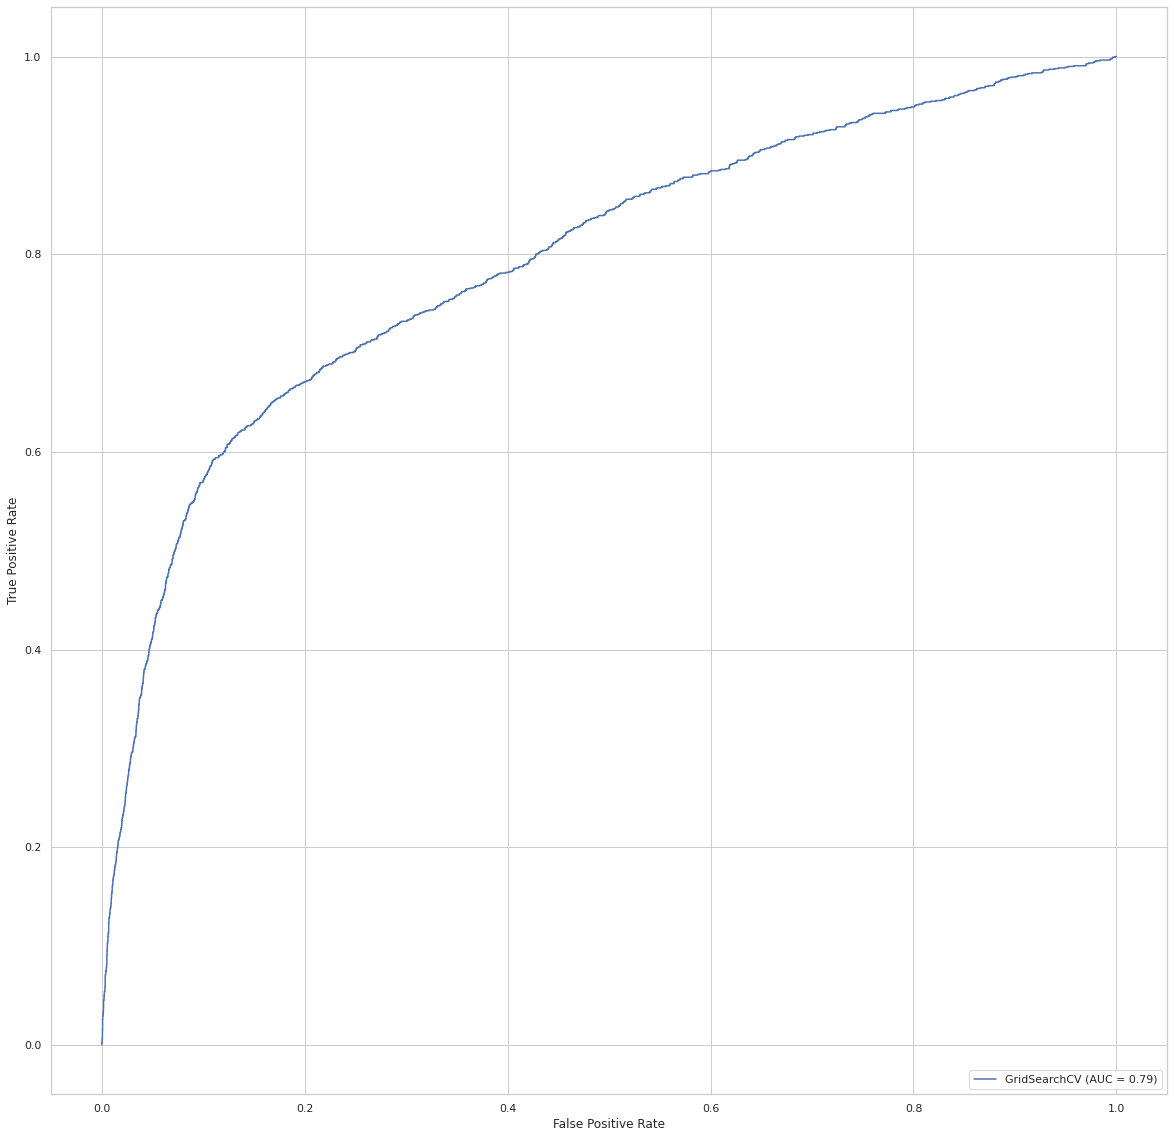

In [36]:
plot_roc_curve(gso,X_test,y_test)

In [37]:
confusion_matrix(y_test,gso.predict(X_test))

array([[9271, 1694],
       [ 510,  882]])

Disminuyamos la dimensionalidad para tener un modelo más general. Para esto busquemos la importancia de cada propiedad.

In [38]:
Importancia_ordenada = pd.Series(gso.estimator.feature_importances_,index=X_train_under.columns)
Relevant_columns = list(Importancia_ordenada.sort_values().tail(20).index)

<AxesSubplot:>

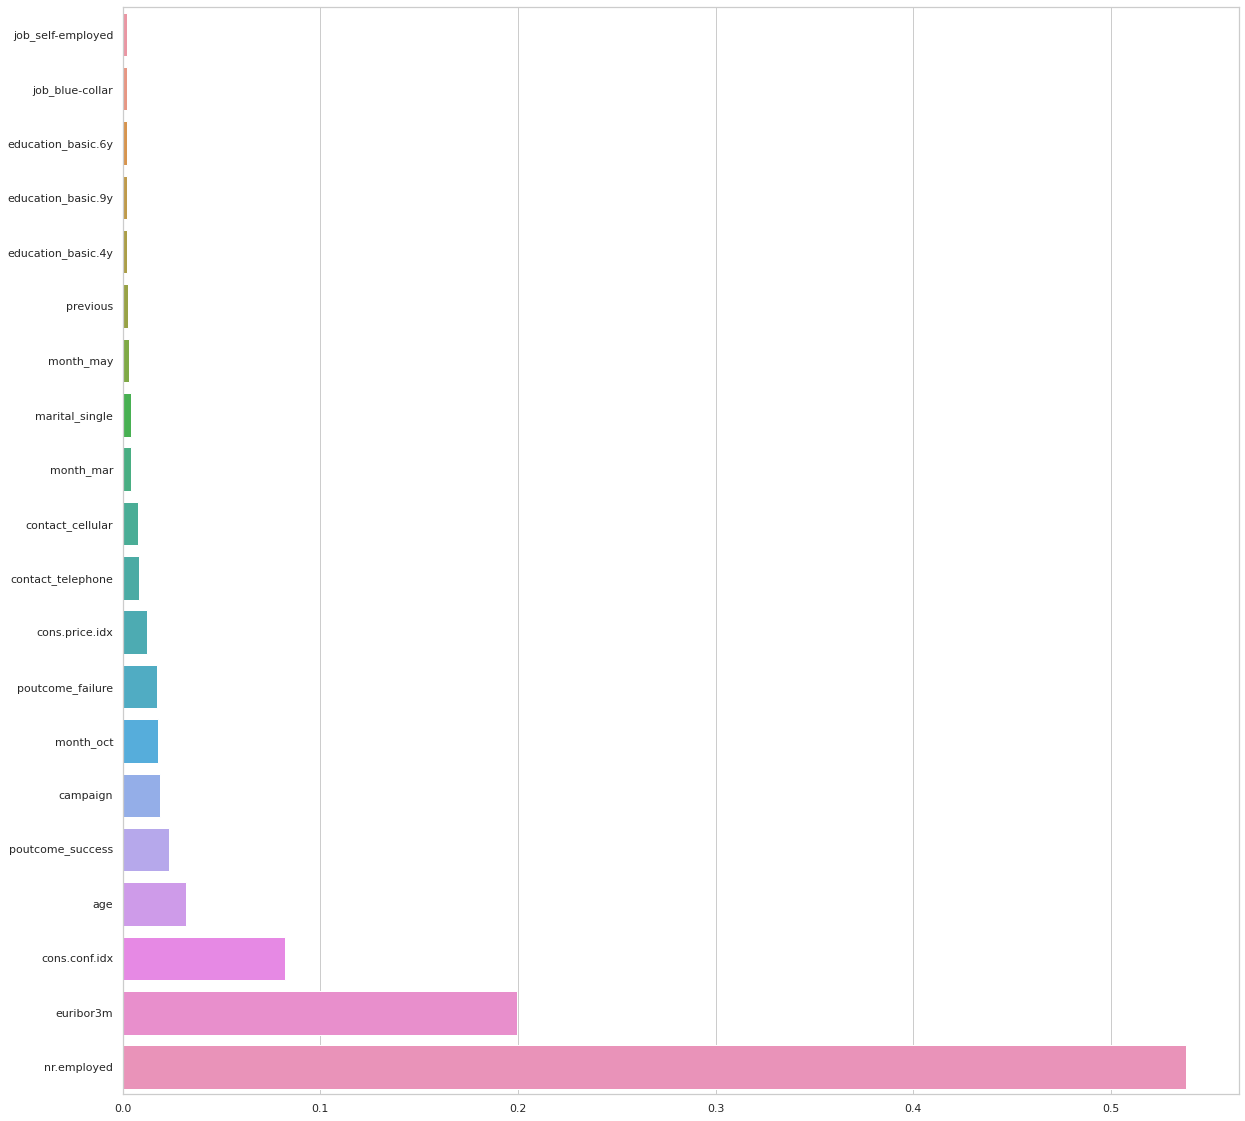

In [39]:
sns.barplot(y=Relevant_columns,x=Importancia_ordenada[Relevant_columns])

Ajustemos hiperparámetros sobre el modelo con dimensiones reducidas.

In [40]:
parametros = {"n_estimators":[50,100,500],"learning_rate":[0.01,0.05,0.1],"max_depth":[3,6,9,12],"max_features":["log2"],"min_samples_leaf":[1,5,10,20,50]}
gso_GB = GridSearchCV(GB,parametros,cv=3,n_jobs=-1,return_train_score=True,scoring="balanced_accuracy")
#gso_GB.fit(X_train_under[Relevant_columns],y_train_under)

In [41]:
Evaluar_Modelos([gso_GB],X_train_under[Relevant_columns],y_train_under,X_test[Relevant_columns],y_test)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 9, 12], 'max_features': ['log2'],
                         'min_samples_leaf': [1, 5, 10, 20, 50],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True, scoring='balanced_accuracy')
ROC auc Score: 0.7420205552148686
F1 Score: 0.45430944963655245
Confusion Matrix: 
[[9380 1585]
 [ 517  875]]
--------------------------------------------------------------------------------


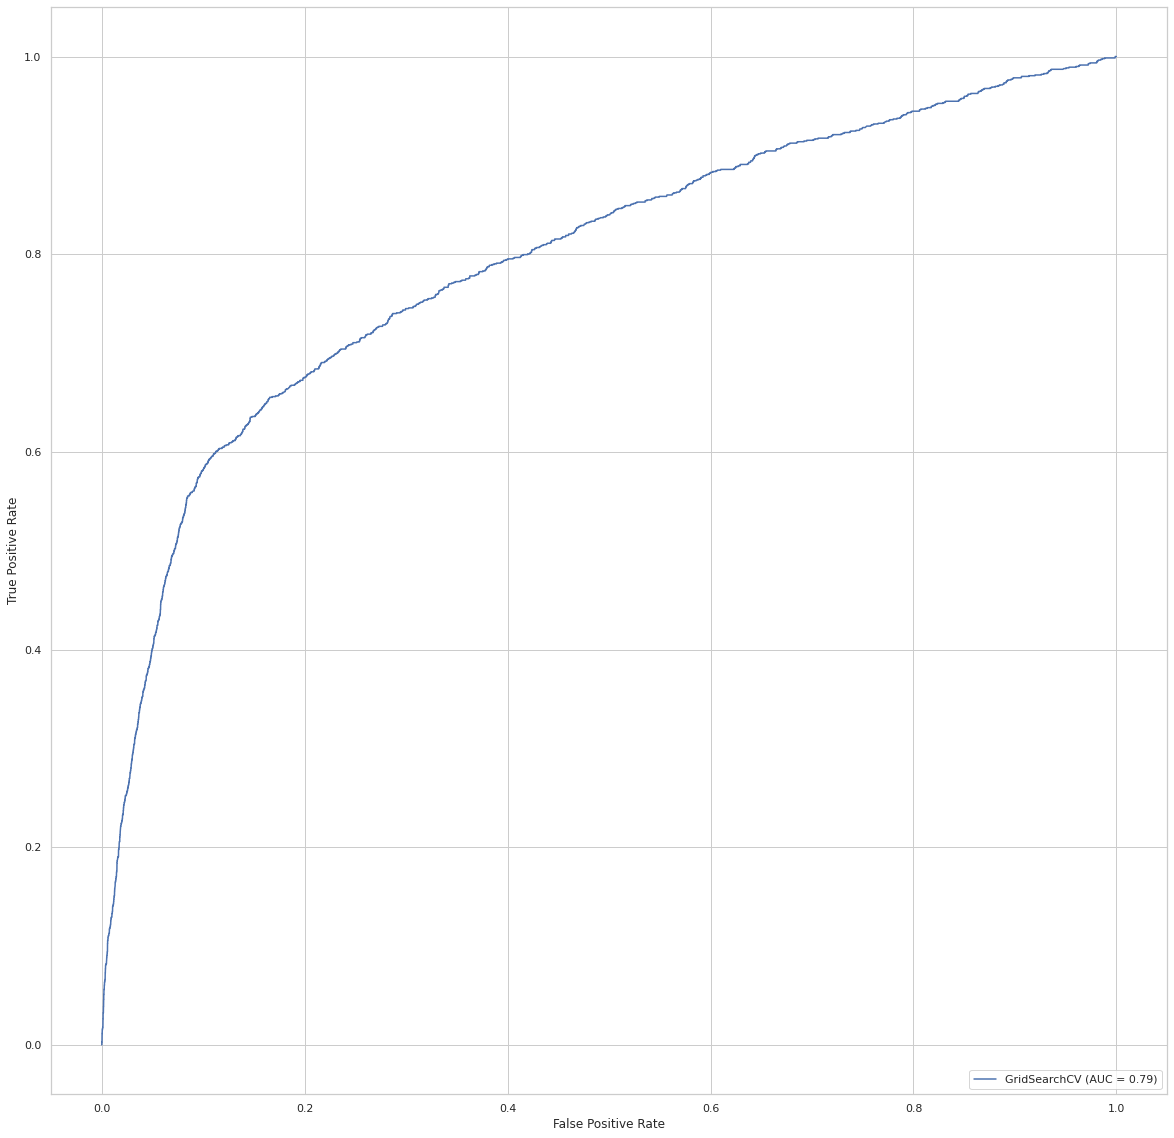

In [42]:
plot_roc_curve(gso_GB,X_test[Relevant_columns],y_test)

Por último comprobemos si utilizo todo los datos para ajustar sin realizar undersampling.

In [44]:
Evaluar_Modelos([gso_GB],X_train[Relevant_columns],y_train,X_test[Relevant_columns],y_test)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 9, 12], 'max_features': ['log2'],
                         'min_samples_leaf': [1, 5, 10, 20, 50],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True, scoring='balanced_accuracy')
ROC auc Score: 0.6164524270012737
F1 Score: 0.2567616300036062
Confusion Matrix: 
[[5106 5859]
 [ 324 1068]]
--------------------------------------------------------------------------------


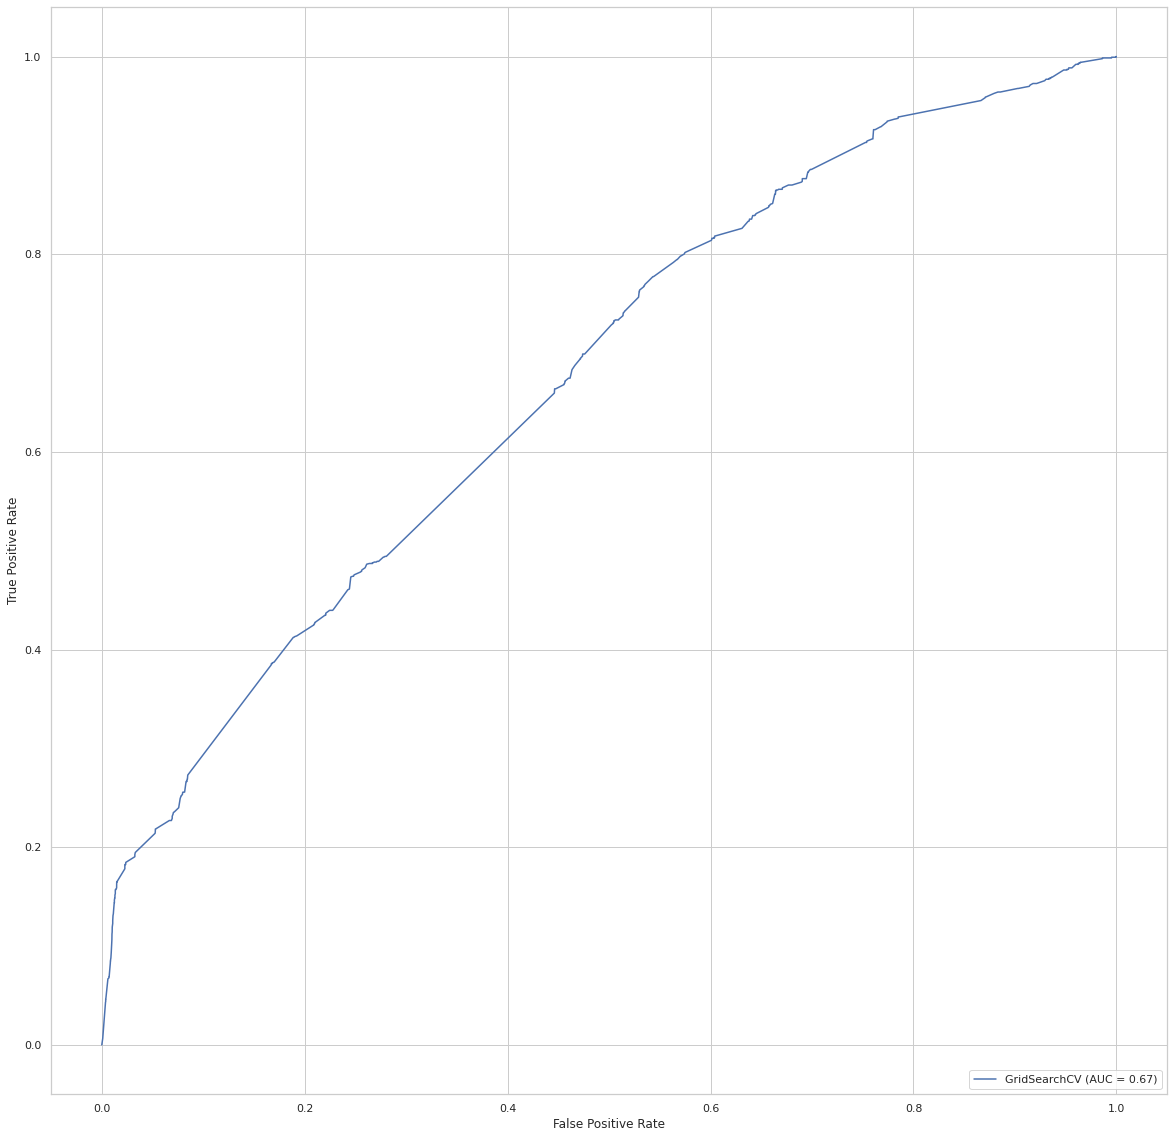

In [46]:
plot_roc_curve(gso_GB,X_test[Relevant_columns],y_test)

El rendimiento es mucho peor con respecto al modelo entrenado con undersampling. Usemos un voting classifier con tres modelos.

In [47]:
params_SVC = {"C":[1,0.1,10],"kernel":["rbf","poly","linear"],"gamma":["scale","auto"]}
params_RF = {"n_estimators":[100,50,30],"min_samples_leaf":[1,50,100]}
gso_SVC = GridSearchCV(SV,params_SVC,n_jobs=-1,cv=3,return_train_score=True)
gso_RF = GridSearchCV(RF,params_RF,n_jobs=-1,cv=3,return_train_score=True)

In [48]:
gso_SVC.fit(X_train_under[Relevant_columns],y_train_under)
gso_RF.fit(X_train_under[Relevant_columns],y_train_under)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 50, 100],
                         'n_estimators': [100, 50, 30]},
             return_train_score=True)

In [49]:
RFF = RandomForestClassifier(**gso_RF.best_params_)
SVCC = SVC(**gso_SVC.best_params_)
GBB = GradientBoostingClassifier(**gso_GB.best_params_)
est = [RFF,SVCC,GBB]

In [52]:
Predictor = VotingClassifier(estimators=[("SVC",SVCC),("GB",GBB),("RF",RFF)])

In [53]:
Evaluar_Modelos([Predictor],X_train_under[Relevant_columns],y_train_under,X_test[Relevant_columns],y_test)

VotingClassifier(estimators=[('SVC', SVC(C=10, gamma='auto')),
                             ('GB',
                              GradientBoostingClassifier(max_depth=12,
                                                         max_features='log2',
                                                         min_samples_leaf=5,
                                                         n_estimators=500)),
                             ('RF',
                              RandomForestClassifier(min_samples_leaf=50,
                                                     n_estimators=50))])
ROC auc Score: 0.7378750176895137
F1 Score: 0.4525316455696203
Confusion Matrix: 
[[9423 1542]
 [ 534  858]]
--------------------------------------------------------------------------------


# Oversampling
Por último analicemos la técnica de oversampling para evitar descartar tanta información.

In [54]:
OverSampler = RandomOverSampler(random_state=101)
X_train_over,y_train_over = OverSampler.fit_resample(X_train,y_train)

In [55]:
Evaluar_Modelos([gso],X_train_over[Relevant_columns],y_train_over,X_test[Relevant_columns],y_test)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9, 12], 'max_features': ['log2'],
                         'min_samples_leaf': [50, 100, 200],
                         'n_estimators': [100, 500]},
             return_train_score=True)
ROC auc Score: 0.5922411827601931
F1 Score: 0.2394044665012407
Confusion Matrix: 
[[3488 7477]
 [ 186 1206]]
--------------------------------------------------------------------------------


Se observa que el mejor modelo encontrado es el GradientBoostingClassifier. A su vez se observa que el modelo entrenado con undersampling posee mejores métricas que los demás. Esto puede deberse a que, aunque no este utilizando todos los datos para entrenar el modelo, la cantidad de datos de entrada es suficiente para realizar un modelo general.